In [1]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt

import skimage as sk
from skimage import measure, filters

from numba import njit, jit, vectorize
from PIL import Image
import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
# width = 512
# height = 512
# channel_no = 3

# #load the libraries
from lib import *
from lib.routines.compute_bdrates import *
# from lib.measure._find_tips_pbc_cy import lookup_segments
# from lib.measure._find_tips_kernel import *
# from lib.measure._find_tips_kernel_cy import find_intersections
#use cuda via numba
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from numba.typed import List
# from lib.contours_to_tips import *

%autocall 1
%load_ext autoreload
%autoreload 2

100000
Automatic calling is: Smart


# TODO: plot two nearby frames of tips and functionally link them

In [18]:
#TODO: plot a single frame of tips using plt.quiver
# fig1, ax1 = plt.subplots()
# ax1.set_title('Arrows scale with plot width, not view')
# Q = ax1.quiver(X, Y, U, V, units='width')
# qk = ax1.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')

# find a nice theta_threshold

In [101]:
data_dir_log = os.path.join(nb_dir,'Figures/methods/tip_log_ic_200x200.120.32_V_0.4__t_1e+03.csv')
df = pd.read_csv(data_dir_log)
df['grad_u_mag'] = df['grad_ux']**2 + df['grad_uy']**2
df['grad_v_mag'] = df['grad_vx']**2 + df['grad_vy']**2
df['theta_comp'] = np.abs(np.pi/2-df['theta'])


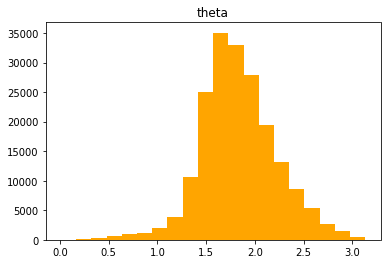

In [102]:
col = 'theta'
values = df[col].values
plt.hist(values,bins = 20, color='orange')
plt.title(col)
plt.show()

In [104]:
print(df.columns)
#summary statistics for each column
df.describe().T[[
    'min',
    'max'
]].T

Index(['t', 'n', 'x', 'y', 'theta', 'grad_ux', 'grad_uy', 'grad_vx', 'grad_vy',
       'v', 'f', 's', 'dvdt', 'dfdt', 'dsdt', 'grad_u_mag', 'grad_v_mag',
       'theta_comp'],
      dtype='object')


,t,n,x,y,theta,grad_ux,grad_uy,grad_vx,grad_vy,v,f,s,dvdt,dfdt,dsdt,grad_u_mag,grad_v_mag,theta_comp
min,500.0,6.0,0.000001,0.000594,0.009657,-47421.204764,-98663.593328,-872126.015134,-120463.408507,0.236417,0.000003,0.670323,-0.007617,-0.015415,-0.001097,1.002346e+00,1.034120e+00,0.000003
max,1000.0,16.0,199.998907,199.997691,3.133060,71555.306143,60095.555167,41462.790237,565070.209264,0.598606,0.200864,0.877856,0.012283,-0.000000,-0.000838,1.142413e+10,1.079908e+12,1.562264


In [105]:
dg = df#.query('t < 1000')

theta_comp is the nonnegative angle complementary to theta


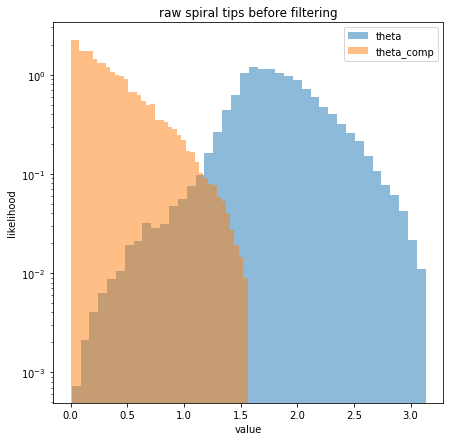

In [106]:
plt.figure(figsize=(7,7))
col_lst = ['theta', 'theta_comp']
print("theta_comp is the nonnegative angle complementary to theta")
for col in col_lst:
    values = dg[col].values
    plt.hist(values,bins = 40, label = col, alpha=0.5, log=True, density=True)
plt.legend()
plt.xlabel('value')
plt.ylabel('likelihood')
plt.title('raw spiral tips before filtering')
# plt.xticks([0,0.5,1,1.5,2,2.5,3,1.1,1.2,1.3,1.4,1.2])
# plt.xlim([1.2,1.4])
plt.show()

In [107]:
1/np.sqrt(2)
theta_comp_threshold = 1*np.pi/3
print(f"please consider theta_comp_threshold = {theta_comp_threshold:.3f}...")
print(f"TODO: try tracking with some memory mem>=2.")

please consider theta_comp_threshold = 1.047...
TODO: try tracking with some memory mem>=2.


# visualize histograms of EP features (not clearly helpful to filtering)

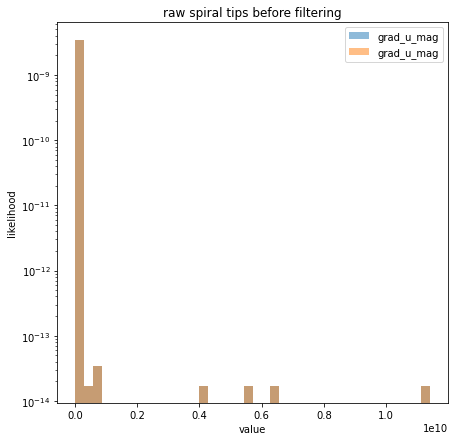

In [78]:
plt.figure(figsize=(7,7))
col_lst = ['grad_u_mag', 'grad_u_mag']
for col in col_lst:
    values = dg[col].values
    plt.hist(values,bins = 40, label = col, alpha=0.5, log=True, density=True)
plt.legend()
plt.xlabel('value')
plt.ylabel('likelihood')
plt.title('raw spiral tips before filtering')
# plt.xticks([0,0.5,1,1.5,2,2.5,3,1.1,1.2,1.3,1.4,1.2])
# plt.xlim([1.2,1.4])
plt.show()

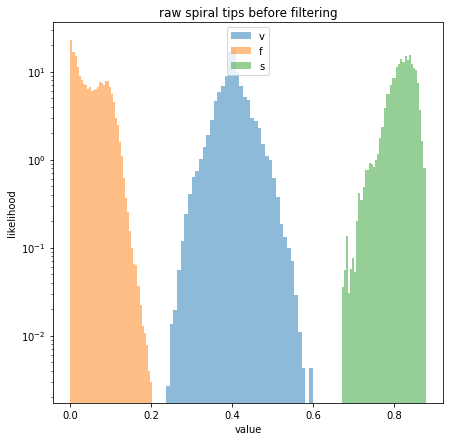

In [79]:
plt.figure(figsize=(7,7))
col_lst = ['v', 'f', 's'] 
for col in col_lst:
    values = dg[col].values
    plt.hist(values,bins = 40, label = col, alpha=0.5, log=True, density=True)
plt.legend()
plt.xlabel('value')
plt.ylabel('likelihood')
plt.title('raw spiral tips before filtering')
# plt.xticks([0,0.5,1,1.5,2,2.5,3,1.1,1.2,1.3,1.4,1.2])
# plt.xlim([1.2,1.4])
plt.show()

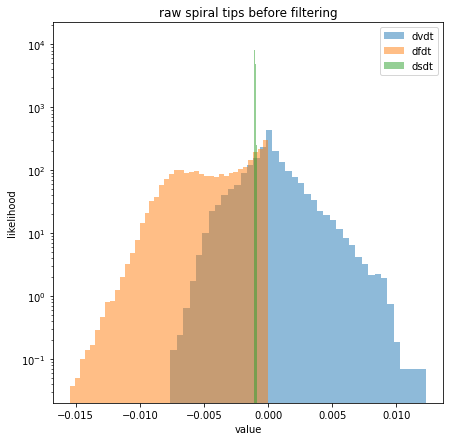

In [80]:
plt.figure(figsize=(7,7))
col_lst = ['dvdt', 'dfdt', 'dsdt']
for col in col_lst:
    values = dg[col].values
    plt.hist(values,bins = 40, label = col, alpha=0.5, log=True, density=True)
plt.legend()
plt.xlabel('value')
plt.ylabel('likelihood')
plt.title('raw spiral tips before filtering')
# plt.xticks([0,0.5,1,1.5,2,2.5,3,1.1,1.2,1.3,1.4,1.2])
# plt.xlim([1.2,1.4])
plt.show()

In [45]:
#good sanity check but doesn't identify any bad tips here.
dsdt_thresh=-0.0007
print(f"It is {(df['dsdt']>dsdt_thresh).values.any()} that any unfiltered spiral tips were observed with dsdt>{dsdt_thresh}.")

It is False that any unfiltered spiral tips were observed with dsdt>-0.0007.


# TODO: consider tracking/filtering tips on the basis of moving in the direction of grad_u (or grad_v)
- TODO: see solution for automated tip detection
- TODO: visualize the histogram of angles between grad_u and the displacement between frames for each row resulting from ^that
- TODO: is there any bimodal distribution?  If not, consider variations on a them.  e.g., grad_v... np.cross... etc...

# TODO: try a DataFrame filter and view the resulting bdrates (on a histogram?)

In [108]:
data_dir_log = os.path.join(nb_dir,'Figures/methods/tip_log_ic_200x200.120.32_V_0.4__t_1e+03.csv')
df = pd.read_csv(data_dir_log)
df['grad_u_mag'] = df['grad_ux']**2 + df['grad_uy']**2
df['grad_v_mag'] = df['grad_vx']**2 + df['grad_vy']**2
df['theta_comp'] = np.abs(np.pi/2-df['theta'])

In [110]:
#first: use the trivial filter
# "tip_log_ic_200x200.120.32_V_0.4__t_1e+03.csv"
boo = [i is not None for i in df.index]
dg = df.loc[boo]

dh = dg.groupby('t').mean()[['n']]
dh.reset_index(inplace=True)

In [116]:
t_series = dh.t
n_series = dh.n

In [134]:
d = compute_bdrates(n_series,t_series).dropna()

In [137]:
d.describe()

,t,n,dn,rates
count,27.000000,27.000000,27.000000,27.000000
mean,791.401852,10.962963,0.074074,0.397100
std,153.404389,2.793970,2.036700,1.089967
min,527.125000,6.000000,-2.000000,0.011474
25%,664.612500,9.000000,-2.000000,0.036920
50%,814.800000,10.000000,2.000000,0.063898
75%,920.600000,13.000000,2.000000,0.290404
max,995.225000,16.000000,2.000000,5.714286


27
0.39710001958551644
1.0695924036783464


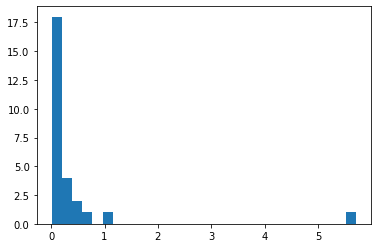

In [149]:
print(d.rates.values.size)
print(d.rates.values.mean())
print(d.rates.values.std())

plt.hist(d.rates.values, bins=30)
plt.show()

- DONE: visualize bdrates for a sanity check
- TODO: get generate_tip_logs_cy up and running
- TODO: start ^that on UB
- TODO: continue playing with filters here
- with (filtered) tip locations,
    - TODO: visualize bdrates
    - TODO: compute trajectories 
    - TODO: visualize MSD
    

In [176]:
t_series = dh.t
n_series = dh.n

20001


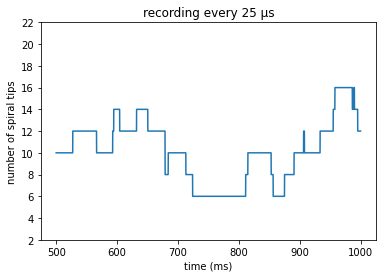

In [177]:
x_values = t_series.values
y_values = n_series.values

num_observations = len(x_values)
print(num_observations)

save = False
plt.plot(x_values,y_values)
plt.title(f"recording every 25 µs")
plt.xlabel(f"time (ms)")
plt.ylabel(f"number of spiral tips")
# ax.set_xticks([])
plt.yticks([2,4,6,8,10,12,14,16,18,20,22])
if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    plt.savefig(f"example_ic_200x200.120.32_num_tips_t_0_{t:.1}_V_{V_threshold}.png")
    #     plt.savefig('example_no_high_frequency_birth_deaths_t_500_600.png')

## visualize birth death rates

In [179]:
# #import data
# os.chdir(folder_name)
# df = pd.read_csv(file_out)

#drop termination times
# df.dropna(inplace=True)
df = d.copy()

#drop rows with rates over 100/ms
df = df.loc[df.rates<=1].copy()

# df = df.loc[df.rates<=0.02].copy()
# df = df.loc[df.rates<=0.1].copy()

dn_list = sorted(set(df.dn.values))
dn_list = [-2,2]

In [180]:
np.mean(df.n.values)

10.923076923076923

In [181]:
#compute median rates and IQR for the error bars corresponding to each category in dn_list
errorbar_data_list = []
for dn in dn_list:  
    #iterate over n for each dn
    df2 = df.loc[df.dn==dn].copy()
    n_list = sorted(set(df2.n.values))
    y_val_list = []
    y_err_1_list = []
    y_err_2_list = []
    for n in n_list:
        df3 = df2.loc[df2.n == n].copy()
        y_val, y_err_1, y_err_2 = df3.describe().T[['50%', '25%', '75%']].loc['rates'].values
        y_err_2 = float(y_err_2 - y_val)
        y_err_1 = float(y_val - y_err_1)
        y_val = float(y_val)
        y_val_list.append(y_val)
        y_err_1_list.append(y_err_1)
        y_err_2_list.append(y_err_2)
    # errorbar_data = (dn, n_list, y_val_list, y_err_1_list, y_err_2_list)
    errorbar_data = {'dn':dn, 
                     'n_list':n_list, 
                     'y_val_list':y_val_list, 
                     'y_err_1_list':y_err_1_list, 
                     'y_err_2_list':y_err_2_list
                    }
    errorbar_data_list.append(errorbar_data)    

In [182]:
#retrieve scatter plot data points for each category in dn_list
scatter_data_list = []
for dn in dn_list:  
    df2 = df.loc[df.dn==dn].copy()
    x_values = df2.n.values
    y_values = df2.rates.values
    scatter_data = {'dn':dn, 
                     'x_values':x_values, 
                     'y_values':y_values, 
                    }
    scatter_data_list.append(scatter_data)

In [183]:
#assign a color/label/other formatting to each category in dn_list
color_list_raw = ['red', 'blue', 'green', 'orange', 'brown', 'purple']
formatting_data_list = []
for i, dn in enumerate(dn_list):
    formatting_data = {
        'dn': dn,
        'color': color_list_raw[i],
        'label':f'$W_{{{int(dn):+d}}}$'
    }
    formatting_data_list.append(formatting_data)   

In [184]:
assert (len(formatting_data_list) is len(scatter_data_list ))
assert (len(formatting_data_list) is len(errorbar_data_list))

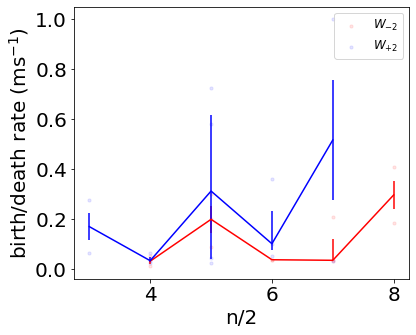

In [185]:
saving = False

savefig_dir = f'{nb_dir}/Figures/birth_death_analysis'
savefig_fn = 'birth_death_rates_ic2-from-log.png'
# savefig_fn = 'birth_death_rates_log.png'
log_scale = False
fontsize=20
figsize=(6,5)

# def birth_death_plot(*y_axis_struct_list):

# plot birth death rates with IQR y error bars with n on the x axis
fig, ax = plt.subplots(figsize=figsize)
for scatter_data, errorbar_data, formatting_data in zip(
    scatter_data_list, errorbar_data_list, formatting_data_list):

    dn, x_values, y_values = scatter_data.values()
    dn, n_list, y_val_list, y_err_1_list, y_err_2_list = errorbar_data.values()
    dn, color, label = formatting_data.values()
    yerr = np.array(list(zip(y_err_1_list,y_err_2_list))).T
    
    ax.scatter(x=x_values/2,y=y_values, c=color, s=10, alpha=0.1, label=label)
    ax.errorbar([n/2 for n in n_list], y_val_list, yerr=yerr, c=color)
    
# ax.legend(loc='top')

# ax.set_xticks([2,4,6,8, 10, 12])
# # ax.set_yticks([0,10,20,30,40,50])
# ymin, ymax = ax.get_ylim()
# ax.set_ylim((1e-3,0.4))

ax.legend(loc='best', fontsize= fontsize-8)
ax.tick_params(axis='both', labelsize= fontsize)
ax.set_ylabel('birth/death rate (ms$^{-1}$)', fontsize=fontsize)
ax.set_xlabel('n/2', fontsize=fontsize) 
if log_scale:
    ax.set_yscale('log')
# ax.set_title(f'$\sigma = {sigma}$, threshold = {threshold}', fontsize=fontsize)
                    
# ax.set_title('high frequency birth deaths observed', fontsize=fontsize)
# ax.axis([20,60,0,7])
  
    
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_dir)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}.")


In [186]:
# import trackpy
y_values.shape
# trackpy.link_iter?

(14,)

In [170]:
#the number when considering rates <= 0.1, we have
y_values.shape

(14,)

In [173]:
df.n.values.shape

(26,)

In [174]:
df[(df.n%2==1)]

,t,n,dn,rates
index,,,,


In [175]:
# from lib.birth_death_rates_from_ic import *
# initial_condition_dir = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-in/ic_200x200.121.33.npz'
# birth_death_rates_from_ic(initial_condition_dir)

# Test the full routine for generating tip logs

In [202]:
from lib.routines.kwargs_cy import get_kwargs
from lib.routines.generate_tip_logs_cy import generate_tip_logs_from_ic
def run_routine(ic):
    kwargs = get_kwargs(ic)
    kwargs = generate_tip_logs_from_ic(ic, **kwargs)
    return True

In [203]:
get_kwargs

<function lib.routines.kwargs_cy.get_kwargs(ic)>

In [204]:
generate_tip_logs_from_ic

<function lib.routines.generate_tip_logs_cy.generate_tip_logs_from_ic(initial_condition_dir, h, tmax, V_threshold, theta_threshold, tmin_early_stopping, save_every_n_frames, round_output_decimals, timing, printing, logging, asserting, beeping, saving, data_dir_log, completed_ic_dir, print_log_dir, **kwargs)>

In [206]:
# ic = search_for_file()
ic = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-in/ic_200x200.121.32.npz'
kwargs = get_kwargs(ic)

In [207]:
kwargs['tmax'] = 100

In [208]:
kwargs = generate_tip_logs_from_ic(ic, **kwargs)

In [209]:
beep(3)

0